<a href="https://colab.research.google.com/github/week4-SpeechRecognition/Speech-to-Text/blob/data_loading/audiopreprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#load packages
import json
import os
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display as  ipd
import torch
import torchaudio
from torchaudio import transforms

In [6]:
os.listdir()

['.config', 'sample_data']

In [10]:
pwd

'/content'

In [ ]:
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_audio_path = 'wav/'
samples, sample_rate = librosa.load(train_audio_path+'tr_9987_tr097069.wav')
print(samples)
print(sample_rate)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: ignored

In [ ]:
audio, rate=librosa.load(train_audio_path+'tr_9987_tr097069.wav', sr=44100)

In [ ]:
ipd.Audio(samples, rate=sample_rate)

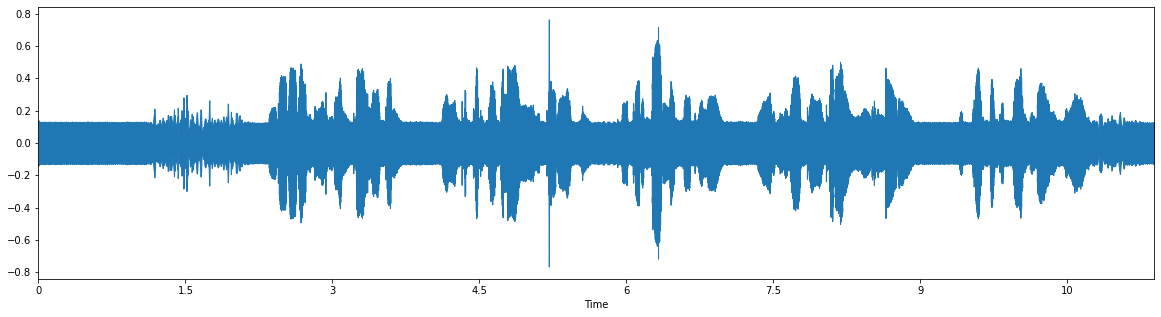

In [ ]:
%matplotlib inline
import librosa.display
#Plot the signal:
plt.figure(figsize=(20, 5))
librosa.display.waveplot(samples, sr=sample_rate)

In [ ]:
from numpy.lib.stride_tricks import as_strided
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [ ]:
spe_samples,frequency=spectrogram(samples)

In [ ]:
frequency

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 

In [ ]:
spe_samples

array([[1.39793768e+00, 1.28199531e+00, 1.30185101e+00, ...,
        1.32269038e+00, 1.30585676e+00, 1.19650308e+00],
       [7.06855605e-01, 6.43173479e-01, 6.56166846e-01, ...,
        6.83285102e-01, 6.64811156e-01, 5.89361629e-01],
       [2.15306154e-06, 2.35603643e-04, 2.02837874e-04, ...,
        1.24786666e-04, 2.57950911e-05, 1.52787090e-04],
       ...,
       [6.55986413e-14, 7.43975256e-16, 3.61865531e-16, ...,
        3.36959794e-16, 1.68656751e-15, 1.81267736e-15],
       [4.27174541e-14, 7.84557023e-16, 2.57583350e-16, ...,
        7.27193536e-16, 3.99654280e-16, 5.64612958e-17],
       [1.67922284e-14, 6.26795856e-16, 7.24763821e-17, ...,
        2.36450932e-16, 6.86012058e-18, 4.77595867e-17]])

Now That we have explored with a sample data let us load as many data from the dataset

> Indented block



# Load the Audio data

In [ ]:
os.listdir()

['spk2utt', 'text', 'trsTrain.txt', 'utt2spk', 'wav.scp', 'wav']

In [ ]:
dataset_path = os.listdir(train_audio_path )

NameError: ignored

In [ ]:
DATASET_PATH = "wav"
SAMPLE_RATE = 22050
labels=[]
def preprocess(dataset_path):
    # dictionary to store files
    
    # loop through all sub-folders
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing at sub-folder level
        if dirpath is not dataset_path:

            # save label (i.e., sub-folder name) in the mapping 
            label = dirpath.split("/")[-1]
           
            print("\nProcessing: {}".format(label))

            # process all audio files in genre sub-dir
            for f in filenames:

		        # load audio file
                filename="wav/"+label+"/"+f
                labels.append(filename)
                 
if __name__ == "__main__":
    preprocess(DATASET_PATH)

In [ ]:
len(labels)

0

In [ ]:
df = pd.read_csv("text",sep="\t",header=None)
df = df.drop([0],axis=1)
#df.columns=['text']
df.head()

""
0
1
2
3
4


## Convert into channels

In [ ]:
chan=[]
for i in df['audio']:
  sig, sr = torchaudio.load(i)
  sig_shape=sig.shape[0]
  chan.append(sig_shape)

KeyError: ignored

In [ ]:
#getting unique values from list
set_channel=set(chan)
print('Unique sound signals',set_channel)

Unique sound signals set()


In [ ]:
def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))